# 1. Finding Similar Customers

## Installing Libraries

In [1]:
%%capture
import os
os.system("pip install wget")
import wget
import gdown
import zipfile

from sortedcontainers import SortedSet, SortedDict
from typing import Dict, Tuple, Iterable, Set, List, Union, Any
from joblib import dump, load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math
import random
import csv

import scipy.integrate as integrate

## Download the [Kaggle Dataset](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation) that we have saved on a S3 Bucket:

In [2]:
def download_zip(url: str) -> None:
  """A function that we'll use to download our files saved on our S3.
  The function works with any type of url.

  Args:
    - url (str): The url where the file is saved.

  Return:
    - None
  """
  print(f"Downloading from {url},", end=" ")
  try:
    filename = wget.download(url)
  except Exception as e:
    print("failed")
    print(e)
  else:
    print("done.")
    print(f"File saved in /content/{filename}")

    if filename.split(".")[-1] == "zip":
      with zipfile.ZipFile(filename, "r") as zip_ref:
        print(f"Unzipping {filename},", end=" ")
        zip_ref.extractall()
        print("done.")
        os.remove(f"/content/{filename}")

In [3]:
download_zip("https://adm-hw4-mep27.s3.amazonaws.com/bank_segmentation.zip")

File saved in /content/bank_segmentation.zip
Unzipping bank_segmentation.zip, done.


In [4]:
df = pd.read_csv("bank_transactions.csv")

## Setting the `TransactionDate` variables to a `datatime` format and displaying the head of the dataframe.

In [5]:
df["TransactionDate"] =  pd.to_datetime(df['TransactionDate'])

df.set_index("CustomerID", inplace=True)

display(df.head())

,TransactionID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
CustomerID,,,,,,,,
C5841053,T1,10/1/94,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0
C2142763,T2,4/4/57,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0
C4417068,T3,26/11/96,F,MUMBAI,17874.44,2016-02-08,142712,459.0
C5342380,T4,14/9/73,F,MUMBAI,866503.21,2016-02-08,142714,2060.0
C9031234,T5,24/3/88,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5


## Taking only the needed columns

We have defined as similiar the customers that have a similar backing scheme in terms of `CustAccountBalance` and `TransactionDate`.

For this reason we preserve as columns:

- CustomerID
- CustAccountBalance
- TransactionDate
- TransactionAmount (INR)

We order the dataframe for `CustomerID` and each customer transactions for `TransactionDate`.

In [6]:
reduced_df = df[["CustAccountBalance", "TransactionDate", "TransactionAmount (INR)"]]\
.sort_values(["CustomerID", "TransactionDate"], ascending=["True", "False"])\

display(reduced_df.head())

,CustAccountBalance,TransactionDate,TransactionAmount (INR)
CustomerID,,,
C1010011,120180.54,2016-09-08,356.0
C1010011,32500.73,2016-09-26,4750.0
C1010012,24204.49,2016-08-14,1499.0
C1010014,38377.14,2016-01-08,1205.0
C1010014,161848.76,2016-07-08,250.0


Some customers have more than one transaction, to handle this we decided to compute a new dataframe which we'll refer to as the `descriptive_dataframe`.
On this particular dataframe we store for each `CustomerID` the descriptive statistics of its `CustAccountBalance` (mean, variance) and `TransactionAmount (INR)` (mean, varinace, sum, count).

In [7]:
def descriptive_dataframe(dataframe: pd.DataFrame) -> pd.DataFrame:
  """Creates a pd.DataFrame which has the descriptive statistics for AccountBalance and TransactionAmount (INR).

  Args:
    - dataframe (pd.DataFrame): A pd.DataFrame on which the result is built.

  Return:
    - result (pd.DataFrame): The descriptive pd.DataFrame.
  """
  balance_insight = dataframe\
                    .groupby('CustomerID')["CustAccountBalance"]\
                    .agg(["mean", "var"])
                    
  balance_insight["var"].fillna(0, inplace=True)
  balance_insight.columns = ["BalanceMean", "BalanceVar"]

  print("Display for the balance insights:")
  display(balance_insight.head())


  transactions_insight = dataframe\
                         .groupby('CustomerID')['TransactionAmount (INR)']\
                         .agg(['sum', 'mean', 'var', 'count'])

  transactions_insight["var"].fillna(0, inplace=True)
  transactions_insight.columns = ["TransactionsSum", "TransactionsMean", "TransactionsVar", "NumTransactions"]

  print()
  print("Display for the transactions insights:")
  display(transactions_insight.head())

  result = balance_insight.join(transactions_insight, on="CustomerID")

  print()
  print("The combined dataframe:")
  display(result.head())

  return result

We chunck the values in steps, in this way we "discretize" the values following the idea that:

>Words of same lenght that have different character are more luckly to be different, while for number this is not true.

Example:

If we take into account three customers whose ballance_mean are of 678, 595 and 1678, even if the first two numbers are different in terms of characters, they are more similar in a backing point of view (both ballance less than 1000) than with the third one which has more characters in common with the first one, but for a backing point of view is much different.

For this reason we decided to add as feature the magnitude for mean, sum and variance (we replace the actual variance for its magnitude) and we step each mean and sum to steps of 500.

In [8]:
def round_avg_sum(x: float,
                  near: int = 1):
  """A function that rounds a given number near a specific number.

  Args:
    - x (float): The number to round up.
    - near (int): The number to use to manage where to round up. Default 1. 
  
  Returns:
    - result (int): The rounded number.
  """
  if x/near - int(x//near) < 0.5:
    result = int(x//near)*near
  else:
    result = int(x//near+1)*near

  return result

def round_variance(x: float):
  """A function that rounds the variance to its order of magnitude

  Args:
    - x (float): The number to round up. It is expected to be not negative.

  Returns:
    - int : The order of magnitude of the input.
  """  
  if int(str(x)[0])>= 5:
   result = round_avg_sum(math.log(x+1, 10))+1
  else:
    result = round_avg_sum(math.log(x+1, 10))

  return result

In [9]:
aggregate_df = descriptive_dataframe(reduced_df)

aggregate_df.dropna(inplace=True)

Display for the balance insights:


,BalanceMean,BalanceVar
CustomerID,,
C1010011,76340.635,3.843875e+09
C1010012,24204.490,0.000000e+00
C1010014,100112.950,7.622620e+09
C1010018,496.180,0.000000e+00
C1010024,87058.650,0.000000e+00



Display for the transactions insights:


,TransactionsSum,TransactionsMean,TransactionsVar,NumTransactions
CustomerID,,,,
C1010011,5106.0,2553.0,9653618.0,2
C1010012,1499.0,1499.0,0.0,1
C1010014,1455.0,727.5,456012.5,2
C1010018,30.0,30.0,0.0,1
C1010024,5000.0,5000.0,0.0,1



The combined dataframe:


,BalanceMean,BalanceVar,TransactionsSum,TransactionsMean,TransactionsVar,NumTransactions
CustomerID,,,,,,
C1010011,76340.635,3.843875e+09,5106.0,2553.0,9653618.0,2
C1010012,24204.490,0.000000e+00,1499.0,1499.0,0.0,1
C1010014,100112.950,7.622620e+09,1455.0,727.5,456012.5,2
C1010018,496.180,0.000000e+00,30.0,30.0,0.0,1
C1010024,87058.650,0.000000e+00,5000.0,5000.0,0.0,1


In [10]:
def preprocess_dataframe(dataframe: pd.DataFrame,
                         step: int = 500) -> pd.DataFrame:
  """The function used to do the preprocessing (discretization) of the values.

  Args:
    - dataframe (pd.DataFrame): The pd.DataFrame we want to preprocess.
    - step (int): The step of discretization. Default 500.

  Returns:
    - df (pd.DataFrame) : A preprocessed pd.DataFrame.
  """
  df = pd.DataFrame()

  df["BalanceVar"] = dataframe["BalanceVar"].apply(lambda x: round_variance(x))
  df["TransactionsVar"] = dataframe["TransactionsVar"].apply(lambda x: round_variance(x))

  df["BalanceMean"] = dataframe["BalanceMean"].apply(lambda x: round_avg_sum(x, step)) 
  df["TransactionsSum"] = dataframe["TransactionsSum"].apply(lambda x: round_avg_sum(x, step)) 
  df["TransactionsMean"] = dataframe["TransactionsMean"].apply(lambda x: round_avg_sum(x, step))

  df["BalanceMeanMagnitude"] = dataframe["BalanceMean"].apply(lambda x: round_variance(x))
  df["TransactionsSumMagnitude"] = dataframe["TransactionsSum"].apply(lambda x: round_variance(x)) 
  df["TransactionsMeanMagnitude"] = dataframe["TransactionsMean"].apply(lambda x: round_variance(x))

  df["NumTransactions"] = dataframe["NumTransactions"]

  display(df.head())

  return df

In [11]:
step = 500

prep_df = preprocess_dataframe(aggregate_df, step)

,BalanceVar,TransactionsVar,BalanceMean,TransactionsSum,TransactionsMean,BalanceMeanMagnitude,TransactionsSumMagnitude,TransactionsMeanMagnitude,NumTransactions
CustomerID,,,,,,,,,
C1010011,10,8,76500,5000,2500,6,5,3,2
C1010012,0,0,24000,1500,1500,4,3,3,1
C1010014,11,6,100000,1500,500,5,3,4,2
C1010018,0,0,500,0,0,3,1,1,1
C1010024,0,0,87000,5000,5000,6,5,5,1


## Grouping similar customers using LSH

### Create the shingles

The idea is to create a dictionary in which for each customer (the key) we save a SOrtedSet containing the tuples (column_name, column_value), in this way for a general customer $i$ we have:


```
customer_i = [('BalanceVar', value), ..., ('NumTransactions', value)]
```

In this way we preserve the sense of the value (which dimension it is refered to).

To mantain this "index" we have created a special class that we have called `Shingles()`.



In [12]:
class Shingles():
  """A class to create and maintain the shingles.

  Args:
    - dataframe (pd.DataFrame): The pd.DataFrame on which we build the shingles. Default None.
    - n_shingles (int): The total number of contained shingles. Default 0.
    - shingles_index (Dict[Tuple[str, int], int]): A dictionary which keys are the shingles and the values their id. Default empty Dict.
    - index_to_shingle (Dict[int, Tuple[str, int]]): A dictionary which keys are the id of the shingles and the values are the shingles it-self. Default empty Dict.
    - n_customers (int): The total number of contained customers. Default 0.
    - customers_index (Dict[str, int]): A dictionary which keys are the customers and the values their id. Default empty Dict.
    - index_to_customer (Dict[int, str]): A dictionary which keys are the id of the customers and the values are the customers it-self. Default empty Dict.
    - docs_to_shingles (Dict[int, SortedSet]): A dictionary that has as keys the documents id and as values the word id of each word contained in that document.
                                               For document we refer to a customer, and the word to the shingle. Default empty Dict.
    - query_shingles (Dict[int, SortedSet]): A dictionary equal to docs_to_shingles but only for query documents.

  Attributes:
    - __n_shingles (int): The private variable where we store the attribute n_shingles.
    - __shingles_index (Dict[Tuple[str, int], int]): The private variable where we store the attribute shingles_index.
    - __index_to_shingle (Dict[int, Tuple[str, int]]): The private variable where we store the attribute index_to_shingle.
    - __n_customers (int): The private variable where we store the attribute n_customers.
    - __customers_index (Dict[str, int]): The private variable where we store the attribute customers_index.
    - __index_to_customer (Dict[int, str]): The private variable where we store the attribute index_to_customer.
    - __docs_to_shingles (Dict[int, SortedSet()]): The private variable where we store the attribute docs_to_shingles.
    - __query_shingles (Dict[int, SortedSet()]): The private variable where we store the attribute query_shingles.
  """
  
  def __init__(self,
               dataframe: pd.DataFrame = None,
               n_shingles: int = 0,
               shingles_index: Dict[Tuple[str, int], int] = {},
               index_to_shingle: Dict[int, Tuple[str, int]] = {},
               n_customers: int = 0,
               customers_index: Dict[str, int] = {},
               index_to_customer: Dict[int, str] = {},
               docs_to_shingles: Dict[int, SortedSet] = {},
               query_shingles: Dict[int, SortedSet] = {}):
    
    self.__n_shingles = n_shingles
    self.__shingles_index = shingles_index
    self.__index_to_shingle = index_to_shingle

    self.__n_customers = n_customers
    self.__customers_index = customers_index
    self.__index_to_customer = index_to_customer

    self.__docs_to_shingles = docs_to_shingles

    self.__query_shingles = query_shingles

    if dataframe is not None:
      self.__add_to_indexes(dataframe)

  def __len__(self) -> int:
    """An override of the __len__ method.

    Returns:
      - int : The total number of shingles.
    """
    return self.__n_shingles

  def __str__(self) -> str:
    """An override of the __str__ method.

    Returns:
      - str : A descriptive string of the class.
    """
    return f"Number of shingles: {self.__n_shingles}.\nNumber of customers: {self.__n_customers}."

  def __get_add__shingle_id(self,
                            shingle: Tuple[str, int]) -> int:
    """A private method to get a shingle_id given a shingle.
    If the shingle is not in the shingles index then we add it.

    Args:
      - shingle (Tuple[str, int]): The shingle of which we want the id.

    Returns:
      - int : The id of the shingle.
    """
    id = self.__shingles_index.get(shingle, 0)

    if id:
      return id

    self.__shingles_index[shingle] = self.__n_shingles
    self.__index_to_shingle[self.__n_shingles] = shingle

    self.__n_shingles += 1

    return self.__n_shingles-1

  def get__n_shingles(self) -> int:
    """It returns the maximum index for the shingles.

    Returns:
      - int : The maximum idec for the shingles.
    """
    return self.__n_shingles

  def get__shingle_id(self,
                      shingle: Tuple[str, int]) -> int:
    """A public method to get a shingle_id given a shingle.

    Args:
      - shingle (Tuple[str, int]): The shingle of which we want the id.

    Returns:
      - id (int): The id of the shingle.
    """
    assert isinstance(shingle, tuple), f"Error: shingle type should a Tuple[str, int], got a {type(shingle)}."

    try:
      id = self.__shingles_index[shingle]
    except:
      raise Exception(f"Error: shingle '{shingle}' not found.")

    return id

  def get__shingle(self,
                   id: int) -> Tuple[str, int]:
    """A public method to retrieve a shingle given its id.

    Args:
      - id (int): The shingle_id.

    Returns:
      - shingle (Tuple[str, int]): The corresponding shingle.
    """
    assert isinstance(id, int), f"Error: id type should be int, got a {type(id)}."

    try:
      shingle = self.__index_to_shingle[id]
    except:
      raise Exception(f"Error: id '{id}' not found.")

    return shingle

  def get__shingles_id(self) -> List[int]:
    """A fucntion that returns all the shingles id.

    Returns:
      - List[int] : The list of shingles id
    """
    return list(self.__shingles_to_docs.keys())

  def __get_add__customer_id(self,
                             customer: str) -> int:
    """A private method to get a customer_id given a customer.
    If the customer is not in the customers index then we add it.

    Args:
      - customer (str): The customer of which we want the id.

    Returns:
      - int : The id of the customer.
    """
    id = self.__customers_index.get(customer, 0)

    if id:
      return id

    self.__customers_index[customer] = self.__n_customers
    self.__index_to_customer[self.__n_customers] = customer

    self.__n_customers += 1

    return self.__n_customers-1

  def get__n_customers(self) -> int:
    """It returns the maximum index for the customers.

    Returns:
      - int : The maximum idec for the customers.
    """
    return self.__n_customers

  def get__customer_id(self,
                       customer: str) -> int:
    """A public method to get a customer_id given a customer.

    Args:
      - customer (str): The customer of which we want the id.

    Returns:
      - id (int): The id of the customer.
    """

    try:
      id = self.__customers_index[customer]
    except:
      raise Exception(f"Error: customer '{customer}' not found.")

    return id

  def get__customer(self,
                    id: int) -> str:
    """A public method that retrieves the customer given its id.

    Args:
      - id (int): The customer id.

    Returns:
      - customer (str): The corresponding customer.
    """
    assert isinstance(id, int), f"Error: id type should be int, got a {type(id)}."

    try:
      customer = self.__index_to_customer[id]
    except:
      raise Exception(f"Error: id '{id}' not found.")

    return customer

  def get__customers_id(self) -> List[int]:
    """A function that returns a list of the customers id.

    Returns:
      - List[int] : The list of custumers id.
    """
    return list(self.__docs_to_shingles.keys())

  def get__customer_shingles(self,
                             customer: Union[str, int]) -> SortedSet:
    """Get the shingle set of a specific customer.

    Args:
      - customer (Union[str, int]): A customer name or id.

    Returns:
      - shingles (SortedSet): The SortedSet of shingles of that customer.
    """
    if isinstance(customer, str):
      try:
        id = self.get__customer_id(customer)
      except:
        raise Exception(f"Error: customer '{customer}' not found.")
      else:
        shingles = self.__docs_to_shingles[id]
    elif isinstance(customer, int):
      try:
        shingles = self.__docs_to_shingles[customer]
      except:
        raise Exception(f"Error: id '{customer}' not found.")
    else:
      raise Exception(f"Expected a str or an int as input, {type(customer)} was given.")

    return shingles

  def __add_to_indexes(self,
                       dataframe: pd.DataFrame) -> None:
    """A function that populates docs_to_shingles and shingles_to_docs, given a dataframe.

    Args:
      - dataframe (pd.DataFrame): The pd.DataFrame on which we want to build our indexes.

    Returns:
      - None
    """

    print("Populating the Shingle object...")
    for customer in tqdm(dataframe.index):

        customer_id = self.__get_add__customer_id(customer)
        self.__docs_to_shingles[customer_id] = SortedSet()

        for word in set(zip(dataframe.loc[customer].index, dataframe.loc[customer])):

          word_id = self.__get_add__shingle_id(word)
          self.__docs_to_shingles[customer_id].add(word_id)

    return None

  def add_query_shingles(self,
                         dataframe: pd.DataFrame) -> List[int]:
    """We add new shingles to our Shingles object.

    Args:
      - dataframe (pd.DataFrame): The pd.DataFrame containing the new customers and shingles.

    Returns:
      - List[int] : The list of query customers id.
    """
    n = self.__n_customers

    print("Populating the Shingle object...")
    for customer in tqdm(dataframe.index):

        customer_id = self.__get_add__customer_id(customer)
        self.__query_shingles[customer_id] = SortedSet()

        for word in set(zip(dataframe.loc[customer].index, dataframe.loc[customer])):

          word_id = self.__get_add__shingle_id(word)
          self.__query_shingles[customer_id].add(word_id)

    return list(range(n, n+len(dataframe)))

  def get__query_customer__shingles(self,
                                    customer_id: int,
                                    id: bool = True) -> SortedSet:
    """Given the customer id of a query customer, this functions returns its shingles.

    Args:
      - customer_id (int): The id of the customer.
      - id (bool): Defines if the customer_id passed as input is indeed a customer di or a customer. Default True.

    Returns:
      - The shingles of that customer.
    """

    if not id:
      try:
        customer_id = self.get__customer_id(customer_id)
      except:
        raise Exception(f"Customer '{customer_id}' not found.")

    try:
      shingles = self.__query_shingles[customer_id]
    except:
      raise Exception(f"Customer id '{customer_id}' not found.")

    return shingles

  def save(self,
            path: str) -> None:
      """To save an Index in a given path.

      Args:
        - path (str): The path where the index is going to be saved.

      Returns:
        - None
      """
      dump(self, path)
      return None

  @classmethod
  def loader(self,
             path: str) -> None:
    """The loader method used to load a saved Shingles object.

    Args:
      - path (str): The path where the file to load is stored.

    Returns:
      - Shingles : A Shingles object.
    """
    return load(path)

We can now create the shingles by intializing a `Shingles` object:

```python
shingles = Shingles(prep_df)
```

This takes around 3 or 4 minutes... to save this time we have performed it in advance and saved the result as a file.pkl:

```python
shingles.save("shingles.pkl")
```
Then we have zipped and store the result on a S3 bucket, so we can directly download it from there and load it:



In [13]:
download_zip("https://adm-hw4-mep27.s3.amazonaws.com/shingles.zip")

File saved in /content/shingles.zip
Unzipping shingles.zip, done.


### Minhashing

- `is_prime()`: Check if the passed number is prime or not.
- `create_hash_functions()`: It creates `n` hash functions.
- `min_wise_hashing__sketch()`: It computes the MinWiseHashing sketch of a shingle set.
- `create__min_wise_hashing__sketches()`: It computes `min_wise_hashing__sketch()` for each customer.

In [14]:
def is_prime(number):
  """Check if a number is prime or not.

  Args:
    - number (int): The number to check.

  Returns:
    - bool : True if the number is indeed prime, else False.
  """
  if number == 2:
      return True
  if (number % 2) == 0:
      return False
  for j in range(3, int(number ** 0.5 + 1), 2):
      if (number % j) == 0:
          return False
  return True

def create_hash_functions(n: int,
                          upper_bound,
                          seed: int = 42):
  """Create n modular hash functions -> h(x) = (a*x + b) mod p .

  Args:
    - n (int): Number of hash functions to create.
    - upper_bound (int): The limit on the variables.
    - seed (int): The seed for the random functions. Default 42.

  Returns:
    - Dict[int, Tuple[int]] : A dictionary that has as keys the number id of the specific hash function,
                              and as values the tuple (a, b, p)
  """
  random.seed(seed)

  functions = {}

  functions_set = set()
  while len(functions_set) < n:
      a = random.randint(1, upper_bound - 1)
      b = random.randint(0, upper_bound - 1)
      p = random.randint(upper_bound, 10 * upper_bound)
      while is_prime(p) == False:
          p = random.randint(upper_bound, 10 * upper_bound)

      functions_set.add((a, b, p))

  for id, values in enumerate(functions_set):
      functions[id] = values

  return functions

def min_wise_hashing__sketch(shingle_set: SortedSet,
                             hash_functions: List[Tuple[int]]) -> List[int]:
  """Given a shingle set and a List of hash functions parameters,
  this function will return the MinWiseHashing sketch of that shingle set.

  Args:
    - shingle_set (SortedSet): A shingle set.
    - hash_functions (List[Tuple[int]]): A list of hash functions parameters.

  Returns:
    - mwh_sketch (List[int]): The MinWiseHashing sketch for the shingle set passed as input.
  """
  mwh_sketch = [float("+inf")] * len(hash_functions)

  for shingle_id in shingle_set:
    index = -1
    for a, b, p in hash_functions:

      index += 1
      hashed_value = (a * shingle_id + b) % p
  
      if hashed_value < mwh_sketch[index]:
        mwh_sketch[index] = hashed_value

  return mwh_sketch

def create__min_wise_hashing__sketches(shingles: Shingles,
                                       n_hash_functions: int,
                                       customers_id: List[int] = None,
                                       seed: int = 42) -> SortedDict:
  """Given a Shingles object and a number of hash functions, it returns the MinWiseHashing sketch for each document.

  Args:
    - shingles (Shingles): The Shingles object.
    - n_hash_functions (int): The number of hash functions.
    - customers_id (List[int]): Subsample of the customers id of the Shingle object.
    - seed (int): The seed used in create_hash_functions(). Default 42.

  Returns:
    - min_wise_hashing__sketches (SortedDict): A dictionary that has as keys the documents id and as values the corresponding MinWiseHashing sketch.
  """
  hash_functions = list(create_hash_functions(n_hash_functions, len(shingles), seed).values())

  min_wise_hashing__sketches = SortedDict()

  if customers_id is None:
    customers_id = shingles.get__customers_id()

    for customer_id in tqdm(customers_id):
      min_wise_hashing__sketches[customer_id] = min_wise_hashing__sketch(shingle_set=shingles.get__customer_shingles(customer_id),
                                                                        hash_functions=hash_functions)
  else:
    for customer_id in tqdm(customers_id):
      min_wise_hashing__sketches[customer_id] = min_wise_hashing__sketch(shingle_set=shingles.get__query_customer__shingles(customer_id),
                                                                        hash_functions=hash_functions)

  return min_wise_hashing__sketches

### Locality-Sensitive Hashing

We define our implementation of the Jaccard Similarity:

In [15]:
def jaccard_similarity(a: Set[Any],
                       b: Set[Any]) -> float:
  """An implementation of jaccard similarity.

  Args:
    - a (Set[Any]): A set.
    - b (Set[Any]): A set.

  Returns:
    - float : The Jaccard Similarity between those sets.
  """
  return len(a.intersection(b))/len(a.union(b))

It is worth noticing that the Jaccard Similarity works even with eterogeneous types of sets, in our case tho we deal with omogeneous types of sets:

- Same length.
- Same dimensions.

So we could work also with a different similarity in weach we have in the numerator the intersection of the two vectors and as denominator the length.

This type of similarity is bigger than the Jaccard one:

In [16]:
n = 9

print("Possible values for Jaccard Similarity:", [(n-i)/(n+i) for i in range(0, n+1)])
print()
print("Possible values if we set the den to len(n)", [(n-i)/n for i in range(0, n+1)])
del n

Possible values for Jaccard Similarity: [1.0, 0.8, 0.6363636363636364, 0.5, 0.38461538461538464, 0.2857142857142857, 0.2, 0.125, 0.058823529411764705, 0.0]

Possible values if we set the den to len(n) [1.0, 0.8888888888888888, 0.7777777777777778, 0.6666666666666666, 0.5555555555555556, 0.4444444444444444, 0.3333333333333333, 0.2222222222222222, 0.1111111111111111, 0.0]


This means that when we have a Jaccard Similarity equal to 0.63 (which means that th length is equal to 7), the other similarity is equal to 0.77.

In our case we set the initial $\text{jaccard_threshold} = \frac7{11}$ because two customers starts to become similar if they have 7 dimmensions in common.

We take the furthest curve at the left (the curve with the most area beneath) to minimize the number of false negatives, after that we'll filter the false positives when we search for the most similar users:

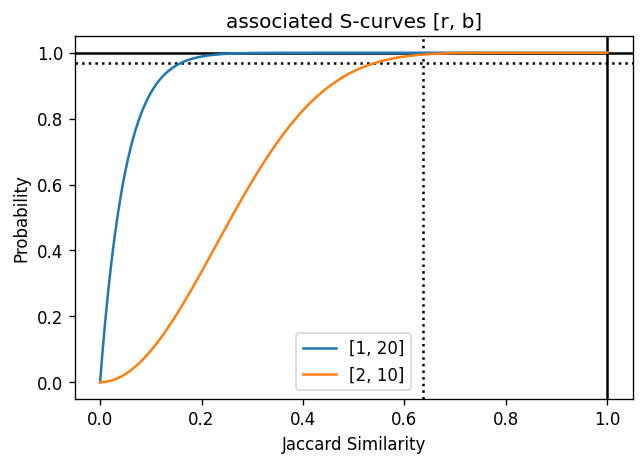

In [17]:
jaccard_threshold = 7/11
n_functions = 20
prob = 0.97

def function(x: float,
             r: int,
             b: int) -> float:
  return 1-(1-x**r)**b

def plot_jaccard(jaccard_threshold: float,
                 prob: float,
                 n_functions: int) -> Tuple[int, int]:
  """A function that plots all the curves generated by all the couples of (r, b)
  which respect the constraints on prob and javvard_threshold.

  Args:
    - jaccard_threshold (float): The threshold on the jaccard similarity between documents in each bin.
    - prob (float): The probabilty of having in each bin documents which are have a jaccard similarity score above the jaccard_threshold.
    - n_functions (int): The number of hash functions to deal with.

  Returns:
    - couple (Tuple[int, int]): The couple of (r, b) that minimize the number of false negatives.
  """
  couples = []

  for i in range(1, int(math.sqrt(n_functions) + 1)):
    if n_functions % i == 0:
      if function(jaccard_threshold, i, n_functions/i) > prob: couples.append((i, int(n_functions/i)))
      if function(jaccard_threshold, n_functions/i, i) > prob and i*i != n_functions: couples.append((int(n_functions/i), i))

  assert len(couples)!=0, "It seems that couples list is empty."

  x = np.linspace(0, 1, num = 1000)

  plt.figure(dpi = 120)
  plt.title("associated S-curves [r, b]")
  plt.xlabel("Jaccard Similarity")
  plt.ylabel("Probability")
  plt.axvline(x = jaccard_threshold, color = 'k', linestyle = ':')
  plt.axhline(y = prob, color = 'k', linestyle = ':')
  plt.axvline(x = 1, color = 'k')
  plt.axhline(y = 1, color = 'k')

  max = 0
  couple = None

  for r, b in couples:
    y = function(x, r, b) 
    plt.plot(x, y, label = f"[{r}, {b}]")

    area = integrate.quad(function, 0, 1, args=(r,b))[0]
    if max < area:
      max = area
      couple = (r, b)

  plt.legend();

  return couple

r, b = plot_jaccard(jaccard_threshold, prob, n_functions)

We define the `LSH()` class which will handle all the functions that we need for Locality Sensitive Hashing.

In [18]:
class LSH():
  """A class to handle the Locality Sensitive Hashing section.

  Args:
    - b (int): The number of bands.

  Attributes:
    - bands (List[Dict[str, List[str]]]): A list of bands, a bands is a Dict which has
                                          as keys...
  """

  def __init__(self,
               b: int):
    
    self.bands = []
    self.b = b
    for _ in range(b):
      self.bands.append({})
    
  def __make_subvects(self,
                      sketch: List[str]) -> np.array:
    """A function to divide a vector in b subvector of r dimension.

    Args:
      - sketch (List[str]): A sketck.

    Returns:
      - np.array : The stack of subvectors.
    """
    n = len(sketch)
    assert n % self.b == 0
    r = int(n / self.b)

    subvecs = []
    for i in range(0, n, r):
      subvecs.append(sketch[i:i+r])
    return np.stack(subvecs)

  def add_sketch(self,
                 sketch: List[str],
                 customer_id: int) -> None:
    """A functions that adds a document (the customer id) to the corresponding bins.

    Args:
      - sketch (List[str]): The MinWiseHashing sketch of the customer id.
      - customer_id (int): The customer id.

    Returns:
      - None
    """
    subvecs = self.__make_subvects(sketch).astype(str)
    for i, subvec in enumerate(subvecs):
      subvec = ",".join(subvec)
      if subvec not in self.bands[i].keys():
        self.bands[i][subvec] = SortedSet()
      self.bands[i][subvec].add(customer_id)

  def add_sketches(self,
                   sketches: Dict[int, List[str]]) -> None:
    """A functions that calls 'add_sketch()' for each sketch in sketches.

    Args:
      - sketches (Dict[int, List[str]]): A dictionary which has as keys the customers id and as values their corresponding sketch.
    
    Returns:
      - None
    """
    for sketch in tqdm(sketches):
      self.add_sketch(sketches[sketch], sketch)

  def single_query(self,
                   sketch: List[str],
                   customer_shingles: SortedSet,
                   shingles: Shingles,
                   t: float) -> SortedSet:
    """A fucntion to query the bins in search of similar customers of our query customer.

    Args:
      - sketch (List[str]): The sketch of our customer.
      - customer_shingles (SortedSet): The shingles of our customer.
      - shingles (Shingles): The Shingles object containing the index of all the shingles.
      - t (float): The jaccard similarity threshold. It can take values between 0 and 1.
    
    Returns:
      - similar (SortedSet): A SortedSet containing all the similar customers of our query customer.
    """
    assert t <= 1 and t >=0, f"Error: t is supposed to be between 0 and 1, instead t equals to {t}."

    similar = SortedSet()

    subvecs = self.__make_subvects(sketch).astype(str)
    for i, subvec in enumerate(subvecs):
      subvec = ",".join(subvec)
      if subvec in self.bands[i].keys():
        for costumer_id in self.bands[i][subvec]:
          if jaccard_similarity(customer_shingles, shingles.get__customer_shingles(costumer_id)) >= t:
            similar.add(costumer_id)

    return similar

  def multiple_query(self,
                     customers_id: List[int],
                     sketches: Dict[int, List[str]],
                     shingles: Shingles,
                     t: float) -> Dict[int, SortedSet]:
    """A functions that calls 'single_query()' for each customer in customers_id.

    Args:
      - customers_id (List[int]): A list of customers id.
      - sketches (Dict[int, List[str]]): The sketches dictionary of those customers id.
      - shingles (Shingles): The Shingles object containing all the shingles.
      - t (float): The jaccard similarity threshold. It can take values between 0 and 1.

    Returns:
      - result (Dict[int, SortedSet]): The dictionary that has as keys the customers id and as values their similar customers.
    """
    assert t <= 1 and t >=0, f"Error: t is supposed to be between 0 and 1, instead t equals to {t}."

    result = {}

    for customer_id in tqdm(customers_id):
      result[customer_id] = self.single_query(sketches[customer_id], shingles.get__query_customer__shingles(shingles.get__customer(customer_id), id=False), shingles, t)

    return result

### From shingles to buckets

We perform the pipeline from the shingles to the lsh.

In [19]:
print("Loading the Shingles object", end="")
shingles = Shingles.loader("shingles.pkl")
print(", done")

print()
print("Some info about the Shingles Object:")
print(shingles)

print()
print(f"Creating all the MinWiseHashing sketches using {n_functions}")
sketches = create__min_wise_hashing__sketches(shingles, n_functions)

lsh = LSH(b)

print()
print("Performing Locality Sensitive Hashing...")
lsh.add_sketches(sketches)

Loading the Shingles object, done

Some info about the Shingles Object:
Number of shingles: 5730.
Number of customers: 882600.

Creating all the MinWiseHashing sketches using 20


  0%|          | 0/882600 [00:00<?, ?it/s]


Performing Locality Sensitive Hashing...


  0%|          | 0/882600 [00:00<?, ?it/s]

## Query time

### Taking the query file:

We download the query file:

In [20]:
query_users_file = gdown.download(url='https://drive.google.com/uc?id=1ob7l9vuujfy8cSNWlpt1shcHWXeLHxPs', quiet=True)

We read the file as a `pd.DataFrame`:

In [21]:
query_users_df = pd.read_csv(query_users_file)

We set the index name to `CustomerID`:

In [22]:
query_users_df.index.name = "CustomerID"

We take a look to the head of the file:

In [23]:
display(query_users_df.head())

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
CustomerID,,,,,,,
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0


### We preprocess the file:

In [24]:
aggregate_query_df = descriptive_dataframe(query_users_df)

Display for the balance insights:


,BalanceMean,BalanceVar
CustomerID,,
0,94695.61,0.0
1,7584.09,0.0
2,7180.60,0.0
3,56847.75,0.0
4,84950.13,0.0



Display for the transactions insights:


,TransactionsSum,TransactionsMean,TransactionsVar,NumTransactions
CustomerID,,,,
0,65.0,65.0,0.0,1
1,6025.0,6025.0,0.0,1
2,541.5,541.5,0.0,1
3,1000.0,1000.0,0.0,1
4,80.0,80.0,0.0,1



The combined dataframe:


,BalanceMean,BalanceVar,TransactionsSum,TransactionsMean,TransactionsVar,NumTransactions
CustomerID,,,,,,
0,94695.61,0.0,65.0,65.0,0.0,1
1,7584.09,0.0,6025.0,6025.0,0.0,1
2,7180.60,0.0,541.5,541.5,0.0,1
3,56847.75,0.0,1000.0,1000.0,0.0,1
4,84950.13,0.0,80.0,80.0,0.0,1


In [25]:
prep_query_df = preprocess_dataframe(aggregate_query_df, step)

,BalanceVar,TransactionsVar,BalanceMean,TransactionsSum,TransactionsMean,BalanceMeanMagnitude,TransactionsSumMagnitude,TransactionsMeanMagnitude,NumTransactions
CustomerID,,,,,,,,,
0,0,0,94500,0,0,6,3,3,1
1,0,0,7500,6000,6000,5,5,5,1
2,0,0,7000,500,500,5,4,4,1
3,0,0,57000,1000,1000,6,3,3,1
4,0,0,85000,0,0,6,3,3,1


### We create the shingles:

In [26]:
query_customers_id = shingles.add_query_shingles(prep_query_df)

Populating the Shingle object...


  0%|          | 0/50 [00:00<?, ?it/s]

In [27]:
print(shingles)

Number of shingles: 5730.
Number of customers: 882650.


### We compute the MinWiseHashing sketches:

In [28]:
query_sketches = create__min_wise_hashing__sketches(shingles, n_functions, query_customers_id)

  0%|          | 0/50 [00:00<?, ?it/s]

### We find the similar users:


We can call the `lsh.multiple_query()` method to retrieve the similars customers for a given list of customers like so:

```python
similars = lsh.multiple_query(query_customers_id, query_sketches, shingles, 0.90)
```

This will take more than an hour, so we have saved the result in our S3 Bucket.

**Note**: it is possibel to reduce the required time by setting the initial jaccard threshold to something like $0.90$ and then taking the couple $(r, b)$ that minimizes the area under the S-curve; in this way we minimize the number of false positives and so the number of jaccard similarity comparison that we have to do at the end... the trade off in doing so is that we're increasing the number of false negatives...

Normally (if resources allow it) it is better to minimize the false negatives, because while it is always possible to reduce false positives in a second step, reducing false negatives afterwards it's impossible.



In [29]:
download_zip("https://adm-hw4-mep27.s3.amazonaws.com/similars.zip")

File saved in /content/similars.zip
Unzipping similars.zip, done.


In [30]:
similars = load("similars.pkl")

We translate each Shingles customer id in normal customer id:

In [31]:
def to__normal__customer_id(d: Dict[int, SortedSet],
                            shingles: Shingles) -> Dict[int, SortedSet]:
  """Translates Shingles customers id in normal customers id.

  Args:
    - d (Dict[int, SortedSet]): The dictionary having as keys customers id and as values similar customers id.
    - shingles (Shingles): The Shingles object.

  Returns:
    - result (Dict[int, SortedSet]): The translated dictionary.
  """
  result = {}

  for customer_id in d:
    result[shingles.get__customer(customer_id)] = SortedSet(map(shingles.get__customer, d[customer_id]))

  return result

In [32]:
similars = to__normal__customer_id(similars, shingles)

### Visualize the results:

In [33]:
def visualize_results(d: Dict[int, SortedSet],
                      query_df: pd.DataFrame,
                      original_df: pd.DataFrame,
                      seed: int = 42):
  """A simple function to visualize a random result.

  Args:
    - d (Dict[int, SortedSet]): The dictionary which has as keys the customers id and as values their similars customers id.
    - query_df (pd.DataFrame): The dataframe with the query customers.
    - original_df (pd.DataFrame): The original dataset.
    - seed (int): The seed for the random module.

  Returns:
    - None
  """
  random.seed(seed)

  customer = random.choice(list(d.keys()))

  print(f"We visualize the query_customer {customer}:")
  display(pd.DataFrame(query_df.loc[customer]))

  print()
  print("We visualize the results:")
  display(original_df.loc[d[customer]])

  return None

In [34]:
visualize_results(similars, aggregate_query_df, aggregate_df)

We visualize the query_customer 40:


,40
BalanceMean,2887.39
BalanceVar,0.00
TransactionsSum,20.00
TransactionsMean,20.00
TransactionsVar,0.00
NumTransactions,1.00



We visualize the results:


,BalanceMean,BalanceVar,TransactionsSum,TransactionsMean,TransactionsVar,NumTransactions
CustomerID,,,,,,
C1012586,2884.96,0.0,30.0,30.0,0.0,1
C1014422,2753.65,0.0,24.0,24.0,0.0,1
C1016170,3017.51,0.0,20.0,20.0,0.0,1
C1016242,2786.47,0.0,16.0,16.0,0.0,1
C1018031,2958.29,0.0,11.0,11.0,0.0,1
...,...,...,...,...,...,...
C9035551,2758.29,0.0,20.0,20.0,0.0,1
C9035720,2992.20,0.0,20.0,20.0,0.0,1
C9037732,2798.95,0.0,30.0,30.0,0.0,1


### We can now check the error of our results:

In [35]:
def check_error(d: Dict[int, SortedSet],
                query_df: pd.DataFrame,
                original_df: pd.DataFrame,
                columns: List[str],
                step: int = 500) -> None:
  """A simple routine to check the error of our results.

  Args:
    - d (Dict[int, SortedSet]): The dictionary which has as keys the customers id and as values their similars customers id.
    - query_df (pd.DataFrame): The dataframe with the query customers.
    - original_df (pd.DataFrame): The original dataset.
    - columns (List[str]): The list of columns on which we want to check the error.
    - step (int): The step of discretization used in preprocessing. Default 500.

  Returns:
  - None
  """
  result = pd.DataFrame()

  for customer_id in d:

    partial = {}

    for column in columns:

      value = query_df.loc[customer_id][column]
      partial[column] = math.sqrt(original_df.loc[d[customer_id]][column].apply(lambda x: (x-value)**2).mean())

    result = pd.concat([result, pd.DataFrame(partial, index=[customer_id])])

  total = np.sum([len(d[elem]) > 1 for elem in d])

  print(f"Number of customers of which we're able to find similar customers: {total} / {len(d)}.")
  print()
  print(f"Number of customers of which we didn't find any similar customers: {len(d)-total} / {len(d)}.")

  print()
  print("Mean of the all errors:")
  display(result.mean())

  print()
  print(f"Are all the error covered by the step '{step}'?", end="\t")

  maximum = result.max()

  answer = np.sum([1 if i <= 500 else 0 for i in maximum.values]) == len(maximum)

  print("Yes." if answer == True else "No.")

  print()
  print("Maximum error:")
  display(result.max())

  print()
  print("Minimum error:")
  display(result.min())

  print()
  print("Display all the errors commited:")
  display(result)

  return None

In [36]:
check_error(similars, aggregate_query_df, aggregate_df, ["BalanceMean", "TransactionsSum", "TransactionsMean"], step=step)

Number of customers of which we're able to find similar customers: 44 / 50.

Number of customers of which we didn't find any similar customers: 6 / 50.

Mean of the all errors:


BalanceMean         170.355200
TransactionsSum      80.999521
TransactionsMean     80.999521
dtype: float64


Are all the error covered by the step '500'?	Yes.

Maximum error:


BalanceMean         303.470497
TransactionsSum     285.377013
TransactionsMean    285.377013
dtype: float64


Minimum error:


BalanceMean         0.0
TransactionsSum     0.0
TransactionsMean    0.0
dtype: float64


Display all the errors commited:


,BalanceMean,TransactionsSum,TransactionsMean
0,271.643097,14.537308,14.537308
1,177.473440,118.236894,118.236894
2,230.045022,85.147266,85.147266
3,156.699582,131.220673,131.220673
4,175.136851,21.338509,21.338509
5,193.991613,27.672753,27.672753
6,198.883448,8.093122,8.093122
7,62.105052,22.167291,22.167291
8,185.090257,27.462625,27.462625
9,0.000000,40.500000,40.500000


### We save the dictionary in a tsv file:

In [37]:
def save__dictionary__to__csv(d: Dict[int, SortedSet],
                              path: str,
                              delimiter: str = ",") -> None:
  """A function to save the dictionary of similar customers in a csv file, similars customers are grouped in lists.

  Args:
    - d (Dict[int, SortedSet]): The dictionary with similars customers.
    - path (str): The path where to save the csv file.
    - delimiter (str): The delimiter to use for the csv file. Default \t.

  Returns:
    - None
  """
  with open(path, 'w', encoding="utf-8") as result:

    csv_writer = csv.writer(result, delimiter=delimiter, quotechar='"', quoting=csv.QUOTE_NONE)
    csv_writer.writerow(["CustomerID", "SimilarCustomers"])

    for customer in d:
      csv_writer.writerow([customer, list(d[customer])])

  return None

In [38]:
save__dictionary__to__csv(similars, "results.tsv", delimiter="\t")

It is possible to download the `result.tsv` as a zip file from [here](https://adm-hw4-mep27.s3.amazonaws.com/results.zip).

# CommandLine Question

Here is another command line question to enjoy. We previously stated that using the command line tools is a skill that Data Scientists must master.

In this question, you should use any command line tools that you know to answer the following questions using the same dataset that you have been using so far:

1. Which location has the maximum number of purchases been made?
2. In the dataset provided, did females spend more than males, or vice versa?
3. Report the customer with the highest average transaction amount in the dataset.

**Note**: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable.

In [39]:
sh = """
# We check if the the .cvs file exists, otherwise we donwload it

if [ ! -f bank_transactions.csv ]; then

  echo 'Downloading the file:'

  # Donwload the zip file from the S3 Bucket
  wget https://adm-hw4-mep27.s3.amazonaws.com/bank_segmentation.zip

  # Unzip the zip file
  unzip -q bank_segmentation.zip

  # Remove the zip file
  rm bank_segmentation.zip

fi  

# Visualize the dataset head
echo 'Visualize the dataset head'
head bank_transactions.csv
echo '---------------------------------------------------------------------------'

# Question 1
echo 'Question 1) First 10 locations with maximum number of purchases:'
awk -F ',' '{print $5}' bank_transactions.csv | sort | uniq -c | sort -nr | head -10
echo '---------------------------------------------------------------------------'

# Question 2
echo 'Question 2) In the dataset provided, did females spend more than males, or vice versa?'

echo 'Females purchases AVG: '
awk -F ',' '$4=="F"{sum+=$9;cnt++}END{print sum/cnt}' bank_transactions.csv
echo 'Females purchases SUM: '
awk -F ',' '$4=="F"{sum+=$9}END{print sum}' bank_transactions.csv

echo 'Males purchases AVG: '
awk -F ',' '$4=="M"{sum+=$9;cnt++}END{print sum/cnt}' bank_transactions.csv
echo 'Males purchases SUM: '
awk -F ',' '$4=="M"{sum+=$9}END{print sum}' bank_transactions.csv

echo 'yes, did females spend more than males'
echo '---------------------------------------------------------------------------'

# Question 3
echo 'Question 3) Customer with the highest average transaction amount in the dataset: '
awk -F ',' '{seen[$2]+=$9; count[$2]++} END{for (x in seen)print  seen[x]/count[x],x}' bank_transactions.csv | sort -nr | head -n 1

wait
"""
with open('CommandLine.sh', 'w') as script:
  script.write(sh)

We make `CommandLine.sh` executable:

In [40]:
os.system("chmod +x CommandLine.sh")

0

We run the shell script with:

In [41]:
print(os.popen('./CommandLine.sh').read())

Visualize the dataset head
TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25
T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999
T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459
T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060
T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
T6,C1536588,8/10/72,F,ITANAGAR,53609.2,2/8/16,173940,676
T7,C7126560,26/1/92,F,MUMBAI,973.46,2/8/16,173806,566
T8,C1220223,27/1/82,M,MUMBAI,95075.54,2/8/16,170537,148
T9,C8536061,19/4/88,F,GURGAON,14906.96,2/8/16,192825,833
---------------------------------------------------------------------------
Question 1) First 10 locations with maximum number of purchases:
 103595 MUMBAI
  84928 NEW DELHI
  81555 BANGALORE
  73818 GURGAON
  71019 DELHI
  32784 NOIDA
  30009 CHENNAI
  25851 PUNE
  23049 HYDERABAD
  21505 THANE
----------------------